In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import numpy as np
import statsmodels as sm
from statsmodels.stats.anova import AnovaRM
import pingouin as pg

In [11]:
trial_number = []
i = 1
while i <= 809:
    trial_number.append(i)
    i += 1


In [12]:
path = "Behavioral/"
all_files = glob.glob(path + "*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    df['trial_number'] = trial_number
    li.append(df)

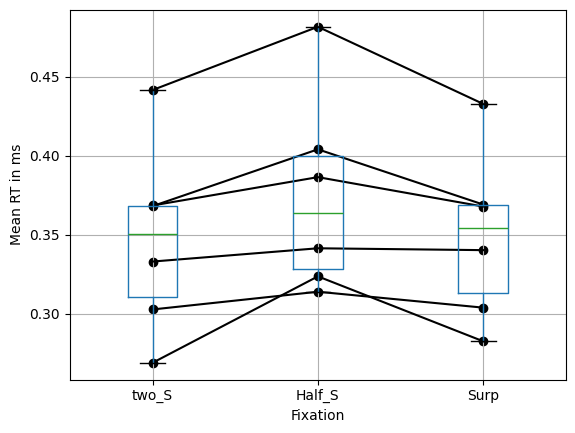

In [13]:
bpmns = []
fig, ax = plt.subplots()
plt.xlabel("Fixation")
plt.ylabel("Mean RT in ms")

for df in li:
    dfmns = []
    
    no = df[(df['FixDur'] == 2) & (df['RT'] >= 0)]
    nf = df[(df['FixDur'] == 0.5) & (df['RT'] >= 0)]
    s  = df[(df['FixDur'] != 2) & (df['FixDur'] != 0.5) & (df['RT'] >= 0)]
    
    # If any of these are empty, skip this df
    if no.empty or nf.empty or s.empty:
        print("Skipping a dataframe due to missing condition(s)")
        continue
    
    dfmns = [no.RT.mean(), nf.RT.mean(), s.RT.mean()]
    bpmns.append(dfmns)

    lts = ['two_S', 'Half_S', 'Surp']
    ax.scatter(lts, dfmns, color='black')
    ax.plot(lts, dfmns, color="black")

# Only plot boxplot if we have data
if bpmns:
    FP_df = pd.DataFrame(np.array(bpmns), columns=['two_S', 'Half_S', 'Surp'])
    FP_df.boxplot(positions=range(len(FP_df.columns)))
else:
    print("No valid data to plot.")


In [27]:
import pandas as pd
import numpy as np
import pingouin as pg

# --- 0) Combine your list of per-file dataframes ---
all_df = pd.concat(li, ignore_index=True)

# Keep only valid RTs and trials you care about
all_df = all_df.loc[all_df['RT'].ge(0) & all_df['trial_number'].notna()].copy()

# --- 1) Build clean current-trial factor "etype" from FixDur ---
def fixdur_to_level(x):
    if pd.isna(x):
        return np.nan
    if x == 0.5:
        return 'half_sec'
    if x == 2:
        return 'two_sec'
    return 'surprise'  # <-- consistent spelling

all_df['etype'] = all_df['FixDur'].map(fixdur_to_level)

# --- 2) Build previous-trial factors using groupby+shift ---
# Sort within participant (and within file if you have a file key) to respect order
sort_cols = ['participant', 'trial_number']
all_df = all_df.sort_values(sort_cols)

all_df['sep_fp']    = all_df.groupby('participant')['FixDur'].shift(1)
all_df['sep_etype'] = all_df.groupby('participant')['etype'].shift(1)

# Optional: if your experiment has "Type" (normal/surprise) and you only want those rows:
# all_df = all_df[all_df['Type'].isin(['normal', 'surprise'])]

# --- 3) Keep only rows with complete factors and numeric RTs ---
use = all_df[
    all_df['etype'].notna() &
    all_df['sep_etype'].notna() &
    pd.to_numeric(all_df['RT'], errors='coerce').notna()
].copy()

use['rt'] = use['RT'].astype(float)
use['participant'] = use['participant'].astype(str)

# --- 4) Aggregate to one value per subject × condition combo (RM-ANOVA expects this) ---
dfm = (use.groupby(['participant', 'etype', 'sep_etype'], as_index=False)['rt']
          .mean())

# --- 5) Balance: keep subjects that have ALL combinations of factors ---
n_e = dfm['etype'].nunique()
n_s = dfm['sep_etype'].nunique()
needed = n_e * n_s
keep_ids = (dfm.groupby('participant')
              .size()
              .pipe(lambda s: s[s == needed].index))
dfm = dfm[dfm['participant'].isin(keep_ids)]

# Drop subjects with zero variance across conditions (singular covariance)
wide = dfm.pivot_table(index='participant', columns=['etype','sep_etype'], values='rt')
var_by_subj = wide.var(axis=1, ddof=1)
dfm = dfm[dfm['participant'].isin(var_by_subj[var_by_subj > 0].index)]

# Quick diagnostics (optional)
print("Participants kept:", dfm['participant'].nunique())
print("Levels etype:", sorted(dfm['etype'].unique()))
print("Levels sep_etype:", sorted(dfm['sep_etype'].unique()))
print(dfm.groupby(['participant','etype','sep_etype']).size().unstack(['etype','sep_etype'], fill_value=0).head())

# --- 6) Two-way RM-ANOVA: current FP × previous FP ---
# If sphericity causes issues, set correction=False (esp. with 3+ levels)
aov = pg.rm_anova(
    data=dfm,
    dv='rt',
    within=['etype', 'sep_etype'],
    subject='participant',
    detailed=True,
    correction=False
)
print(aov)


Participants kept: 6
Levels etype: ['half_sec', 'surprise', 'two_sec']
Levels sep_etype: ['half_sec', 'surprise', 'two_sec']
etype       half_sec                  surprise                   two_sec  \
sep_etype   half_sec surprise two_sec half_sec surprise two_sec half_sec   
participant                                                                
461212             1        1       1        1        1       1        1   
590500             1        1       1        1        1       1        1   
617985             1        1       1        1        1       1        1   
666227             1        1       1        1        1       1        1   
705027             1        1       1        1        1       1        1   

etype                         
sep_etype   surprise two_sec  
participant                   
461212             1       1  
590500             1       1  
617985             1       1  
666227             1       1  
705027             1       1  
              Sour

C:\Users\bhdib\.virtualenvs\SwanLab_Figures_FP-MNBlZaqf\Lib\site-packages\pingouin\distribution.py:515: UserWarning: Epsilon values might be innaccurate in two-way repeated measures design where each  factor has more than 2 levels. Please  double-check your results.
  warnings.warn(


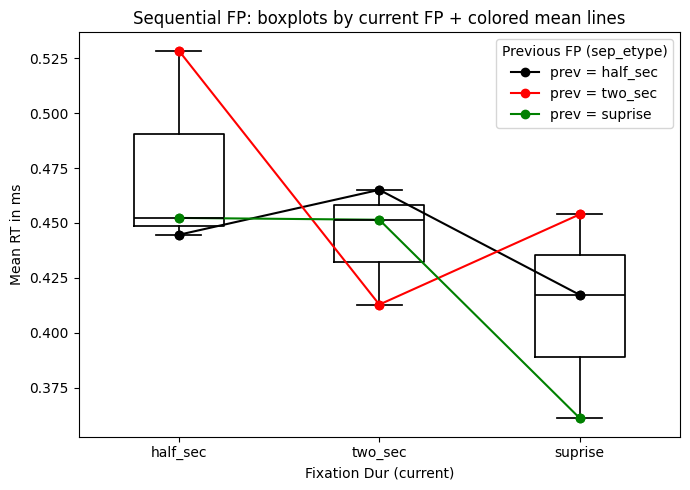

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- keep your inputs/objects: sdf, getmn ---
# NOTE: If you actually meant 'surprise', consider normalizing spelling:
# sdf = sdf.replace({'suprise': 'surprise'})

# Colors per previous FP (sep_etype)
color_map = {'half_sec': 'black', 'two_sec': 'red', 'suprise': 'green'}

# X-axis order for CURRENT FP (og_etype)
curr_levels = ['half_sec', 'two_sec', 'suprise']
xpos = np.arange(len(curr_levels))  # [0,1,2]

# Build the bpmns matrix exactly like your original (rows = prev FP, cols = current FP means)
fps = ['half_sec', 'two_sec', 'suprise']
bpmns = []
for prev in fps:
    means_row = []
    for cur in curr_levels:
        sub = sdf[(sdf['og_etype'] == cur) & (sdf['sep_etype'] == prev)]
        means_row.append(getmn(sub['og_rt']))
    bpmns.append(means_row)

FP_df = pd.DataFrame(np.array(bpmns), columns=curr_levels, index=fps)

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel("Fixation Dur (current)")
ax.set_ylabel("Mean RT in ms")

# 1) BOX-PLOTS (unfilled, slim, black edges)
# Matplotlib expects "list of arrays" per box in order of positions
box_data = [FP_df[col].astype(float).values for col in curr_levels]  # 3 arrays
bp = ax.boxplot(
    box_data,
    positions=xpos,
    widths=0.45,
    patch_artist=False,     # <- no fill (classic look)
    showfliers=False,       # optional: hide outliers to keep things tidy
    whis=1.5
)

# Subtle styling (optional)
for element in ['boxes','whiskers','caps','medians']:
    plt.setp(bp[element], color='black', linewidth=1.25)

# 2) COLORED LINES per previous FP across current FP
for prev in fps:
    y = FP_df.loc[prev, curr_levels].astype(float).values
    ax.plot(xpos, y, marker='o', linestyle='-', color=color_map[prev], label=f"prev = {prev}")
    ax.scatter(xpos, y, color=color_map[prev], zorder=3)

ax.set_xticks(xpos)
ax.set_xticklabels(curr_levels)
ax.legend(title="Previous FP (sep_etype)")
ax.set_title("Sequential FP: boxplots by current FP + colored mean lines")

ax.margins(x=0.05)
plt.tight_layout()
plt.show()


In [33]:
import mne
import matplotlib.pyplot as plt
from glob import glob
import os

# === Settings ===
data_folder = './BDF'  # Change this to your directory
channels_to_plot = ['Fz', 'Cz', 'Pz', 'O1', 'O2']
output_folder = './spectrograms/'
os.makedirs(output_folder, exist_ok=True)

# === Loop through BDF files ===
bdf_files = glob(os.path.join(data_folder, '*.bdf'))

for bdf_path in bdf_files:
    print(f"Processing: {bdf_path}")
    try:
        raw = mne.io.read_raw_bdf(bdf_path, preload=True)
    except Exception as e:
        print(f"Failed to read {bdf_path}: {e}")
        continue

    # Sanitize filename
    base_name = os.path.splitext(os.path.basename(bdf_path))[0]

    # Loop through selected channels
    for ch in channels_to_plot:
        if ch not in raw.ch_names:
            print(f"Channel {ch} not found in {bdf_path}. Skipping.")
            continue

        try:
            raw_copy = raw.copy().pick_channels([ch])
            data, times = raw_copy[:]
            signal = data[0]
            sfreq = raw_copy.info['sfreq']

            # Plot and save spectrogram
            plt.figure(figsize=(10, 6))
            plt.specgram(signal, NFFT=1024, Fs=sfreq, noverlap=512, cmap='plasma')
            plt.title(f"Spectrogram - {ch} - {base_name}")
            plt.xlabel("Time [s]")
            plt.ylabel("Frequency [Hz]")
            plt.colorbar(label='Intensity [dB]')
            plt.tight_layout()

            output_path = os.path.join(output_folder, f"{base_name}_{ch}_spectrogram.png")
            plt.savefig(output_path)
            plt.close()
            print(f"Saved: {output_path}")

        except Exception as e:
            print(f"Error processing {ch} in {bdf_path}: {e}")


Processing: ./BDF\Foreperiod_Jmlah.bdf
Extracting EDF parameters from C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF\Foreperiod_Jmlah.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2910207  =      0.000 ...  2841.999 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: ./spectrograms/Foreperiod_Jmlah_Fz_spectrogram.png
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: ./spectrograms/Foreperiod_Jmlah_Cz_spectrogram.png
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: ./spectrograms/Foreperiod_Jmlah_Pz_spectrogram.png
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: ./spectrograms/Foreperiod_Jmlah_O1_spectrogram.png
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved: ./spectrograms/Foreperiod_Jmlah_O2_spectrogram.png
Processing: ./BDF\Fo

In [ ]:
import mne
import matplotlib.pyplot as plt

# === Load BDF file ===
bdf_path = '/BDF/Jmlah.bdf'  # Replace with your file path
raw = mne.io.read_raw_bdf(bdf_path, preload=True)

# === Pick one channel (e.g., Cz or the first EEG channel) ===
channel_name = 'Cz'  # Change this to a channel in your data
raw.pick_channels([channel_name])

# === Get the data and sampling rate ===
data, times = raw[:]
sfreq = raw.info['sfreq']
signal = data[0]

# === Plot spectrogram ===
plt.figure(figsize=(10, 6))
plt.specgram(signal, NFFT=1024, Fs=sfreq, noverlap=512, cmap='plasma')
plt.title(f"Spectrogram of {channel_name}")
plt.xlabel("Time [s]")
plt.ylabel("Frequency [Hz]")
plt.colorbar(label='Intensity [dB]')
plt.tight_layout()
plt.show()


In [ ]:
event_id = {
    'f_fixation': 1,
    'f_target': 2,
    'f_click': 3,
    's_fix': 4,
    's_target': 5,
    '!_fix': 7,
    '!_target': 8,
    '!_click': 9,
}

import mne
import matplotlib.pyplot as plt
import glob
import os

# Directory containing BDF files
bdf_directory = r'C:\Users\bhdib\OneDrive\Desktop\SwanLab_Figures_FP\BDF'
task = 'ForePeriod'

# Find all .bdf files in the directory
bdf_files = glob.glob(os.path.join(bdf_directory, '*.bdf'))

# Iterate over each file
for i, file_path in enumerate(bdf_files, start=1):
    id_num = f"{i:02d}"  # Format ID as 01, 02, etc.

    print(f"Processing {file_path}...")

    # Load data
    raw = mne.io.read_raw_bdf(file_path, preload=True)

    # Set channel types for non-EEG channels
    raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if ch in ['Erg1', 'Erg2']})
    raw.set_channel_types({ch: 'misc' for ch in raw.ch_names if 'EXG' in ch})

    # Set montage, ignoring channels without positions
    raw.set_montage(mne.channels.make_standard_montage('biosemi64'), on_missing='ignore')

    # PSD plot
    psd = raw.compute_psd(fmax=100)
    fig_psd = psd.plot(show=False)
    fig_psd.savefig(os.path.join(bdf_directory, f"psd_plot_{id_num}.png"))

    # Event detection
    events = mne.find_events(raw, stim_channel="Status", shortest_event=0.05)

    # Build event_id automatically if not defined
    event_ids = {str(e): e for e in set(events[:, 2])}

    # Plot events
    fig_events = mne.viz.plot_events(events, sfreq=raw.info['sfreq'], event_id=event_ids, show=False)
    fig_events.savefig(os.path.join(bdf_directory, f"events_plot_{id_num}.png"))

plt.show()


In [ ]:
#optional other boxplot

# clear out lists while troubleshooting
bpmns = []
fig, ax=plt.subplots()
plt.xlabel("Fixation")
plt.ylabel("Mean RT in ms")
for df in li:
    dfmns = []
    no = df[(df['FixDur'] == 2) & (df['RT'] >= 0)]
    dfmns.append(no.RT.mean())
    nf = df[(df['FixDur'] == 0.5) & (df['RT'] >= 0)]
    dfmns.append(nf.RT.mean())
    s = df[(df['FixDur'] != 2) & (df['FixDur'] != 0.5) & (df['RT'] >= 0)]
    dfmns.append(s.RT.mean())
    bpmns.append(dfmns)
    lst = [no.RT.mean(), nf.RT.mean(), s.RT.mean()]
    lts = ['two_S', 'Half_S', 'Surp']
    ax.scatter(lts, lst, color='black')
    ax.plot(lts,lst, color="black")
    # [fbmn, ffmn, vmn]
FP_df = pd.DataFrame(np.array(bpmns), columns=['two_S', 'Half_S', 'Surp'])
FP_df.boxplot(positions=range(len(FP_df.columns)))

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- keep your inputs/objects: sdf, getmn ---
# NOTE: If you actually meant 'surprise', consider normalizing spelling:
# sdf = sdf.replace({'suprise': 'surprise'})

# Colors per previous FP (sep_etype)
color_map = {'half_sec': 'black', 'two_sec': 'red', 'suprise': 'green'}

# X-axis order for CURRENT FP (og_etype)
curr_levels = ['half_sec', 'two_sec', 'suprise']
xpos = np.arange(len(curr_levels))  # [0,1,2]

# Build the bpmns matrix exactly like your original (rows = prev FP, cols = current FP means)
fps = ['half_sec', 'two_sec', 'suprise']
bpmns = []
for prev in fps:
    means_row = []
    for cur in curr_levels:
        sub = sdf[(sdf['og_etype'] == cur) & (sdf['sep_etype'] == prev)]
        means_row.append(getmn(sub['og_rt']))
    bpmns.append(means_row)

FP_df = pd.DataFrame(np.array(bpmns), columns=curr_levels, index=fps)

# ---- PLOT ----
fig, ax = plt.subplots(figsize=(7,5))
ax.set_xlabel("Fixation Dur (current)")
ax.set_ylabel("Mean RT in ms")

# 1) BOX-PLOTS (unfilled, slim, black edges)
# Matplotlib expects "list of arrays" per box in order of positions
box_data = [FP_df[col].astype(float).values for col in curr_levels]  # 3 arrays
bp = ax.boxplot(
    box_data,
    positions=xpos,
    widths=0.45,
    patch_artist=False,     # <- no fill (classic look)
    showfliers=False,       # optional: hide outliers to keep things tidy
    whis=1.5
)

# Subtle styling (optional)
for element in ['boxes','whiskers','caps','medians']:
    plt.setp(bp[element], color='black', linewidth=1.25)

# 2) COLORED LINES per previous FP across current FP
for prev in fps:
    y = FP_df.loc[prev, curr_levels].astype(float).values
    ax.plot(xpos, y, marker='o', linestyle='-', color=color_map[prev], label=f"prev = {prev}")
    ax.scatter(xpos, y, color=color_map[prev], zorder=3)

ax.set_xticks(xpos)
ax.set_xticklabels(curr_levels)
ax.legend(title="Previous FP (sep_etype)")
ax.set_title("Sequential FP: boxplots by current FP + colored mean lines")

ax.margins(x=0.05)
plt.tight_layout()
plt.show()
